In [1]:
#https://www.tensorflow.org/tutorials/load_data/text
import tensorflow as tf
import keras
import os
import numpy as np
import sys

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [3]:
FILE_NAMES = ['no_hate_sexual.txt', 'hate_sexual.txt']
!wc no_hate_sexual.txt
!wc hate_sexual.txt

    8081  136694  862351 no_hate_sexual.txt
    2772   49321  316263 hate_sexual.txt


In [4]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)  

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(os.path.join(file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [5]:
BUFFER_SIZE = 50000  #Randomness 
BATCH_SIZE = 64  #check if neccesary
TAKE_SIZE = 3000 #5000 in the example ## Test data size

In [6]:
#1 = Hate  0= No Hate

all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
  
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)


In [7]:
for ex in all_labeled_data.take(10):
  print(ex)

(<tf.Tensor: shape=(), dtype=string, numpy=b"who's gonna tell her que cada uno ve la belleza de diferente manera y que ningun gusto es mejor o peor que otro??">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'@Rama3998 Vieron?!! Yo les dije que era un machirulo \xf0\x9f\x98\x95'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Med\xc3\xadquese porfavor se\xc3\xb1ora'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'pero dad la cara, maricones'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'mujer como te amoooo\xf0\x9f\x91\x8f\xf0\x9f\x91\x8f\xf0\x9f\x98\x8d'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'@NightWalkercito @SergiVidal215 @jdomingo442 @elcrustaceorojo Sisi pero dimelo a la cara jajajaj que sois todos unos maricones, os vais a cagar ya vereis cuantos muertos

In [8]:
all_labeled_data = all_labeled_data.prefetch(2)

train_data = all_labeled_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.prefetch(2)

test_data = all_labeled_data.take(TAKE_SIZE)
test_data = test_data.prefetch(2)

train_size = len(list(train_data))
test_size = len(list(test_data))

In [9]:
print("all_labeled_data:")
print(type(all_labeled_data))
print(all_labeled_data)
print(len(list(all_labeled_data)))
print("train_data:")
print(type(train_data))
print(train_data)
print(len(list(train_data)))
print("test_data:")
print(type(test_data))
print(test_data)
print(len(list(test_data)))

all_labeled_data:
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>
10855
train_data:
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>
7855
test_data:
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>
3000


In [10]:
#Examples of train data
for X_batch, y_batch in train_data.batch(5).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Tweet:", review.decode("utf-8")[:10000])
        print("Label:", label, "= Hate" if label == 1 else "= No-Hate")
        print()

Tweet: @enlar_ Maricones
Label: 1 = Hate

Tweet: Pacos maricones
Label: 1 = Hate

Tweet: Un xinO maRiquItA que parece mÁs unA sEñOra que las mIsmaS sEñoRas.
Label: 0 = No-Hate

Tweet: Estoy cansado de el prototipo de travesti moderno, de hoy en adelante seré un maricon con medias y tanga, un poco de maquillaje y perfume barato. Sin pelucas ni postizos. El hombre activo que le vaya mi nuevo género adelanté. https://t.co/zYqMcSuAe6
Label: 0 = No-Hate

Tweet: @Alexpas950 Ese hp es más creído, que día le dije algo y me bloqueó pero antes me escribió un poco de guevonadas que ni leí....Lo he visto varias veces en Armenia y es muy mariquita...
Label: 1 = Hate



In [11]:
#Function to preprocess the train data

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)  #Use the first 300 characters
    X_batch = tf.strings.lower(X_batch)  #To lower case
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ") #Remove tags
    X_batch = tf.strings.regex_replace(X_batch, rb"http\S+", b" ") #Remove html strings
    X_batch = tf.strings.regex_replace(X_batch, rb"[^\P{P}]+", b" ") #Remove punctuation, except 
    X_batch = tf.strings.split(X_batch) #Split by spaces
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [12]:
#Example of preprocessing of train data
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(5, 40), dtype=string, numpy=
 array([[b'enlar', b'maricones', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
        [b'pacos', b'maricones', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
        [b'un',

In [13]:
#Construct Vocabulary

from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in train_data.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [14]:
vocabulary.most_common()[:20]
#CHECK if we should skip STOP WORDS or apply POS to use only N, V & A; OR Unify words?

[(b'<pad>', 253572),
 (b'de', 5124),
 (b'que', 5110),
 (b'y', 3518),
 (b'la', 3302),
 (b'a', 3289),
 (b'no', 2625),
 (b'el', 2223),
 (b'en', 1759),
 (b'es', 1745),
 (b'los', 1589),
 (b'me', 1479),
 (b'un', 1433),
 (b'se', 1421),
 (b'por', 1178),
 (b'lo', 1155),
 (b'una', 1093),
 (b'con', 1016),
 (b'machirulo', 955),
 (b'maricones', 920)]

In [15]:
len(vocabulary)

22265

In [16]:
#Truncate the vocabulary, keeping only the 10,000 most common words
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [17]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"Esta es una prueba de discurso de odio".lower().split():
    print(word_to_id.get(word) or vocab_size)

45
9
16
2458
1
1081
1
191


In [18]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [20]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [21]:
train_set = train_data.repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [22]:
test_set = test_data.repeat().batch(32).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)

In [23]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  226     0     0 ...     0     0     0]
 [    2  1892  1721 ...     0     0     0]
 [10984    17    16 ...     0     0     0]
 ...
 [   97  1478    17 ...     0     0     0]
 [  438     2    11 ...     0     0     0]
 [10946   524   276 ...     0     0     0]], shape=(32, 45), dtype=int64)
tf.Tensor([0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0], shape=(32,), dtype=int64)


In [24]:
'''ACTIVATE THIS ONLY FOR EXTERNAL VALIDATION
ext_val_set = external_validation_dataset.repeat().batch(32).map(preprocess)
ext_val_set = ext_val_set.map(encode_words).prefetch(1)

for X_batch, y_batch in ext_val_set.take(1):
    print(X_batch)
    print(y_batch)
'''

'ACTIVATE THIS ONLY FOR EXTERNAL VALIDATION\next_val_set = external_validation_dataset.repeat().batch(32).map(preprocess)\next_val_set = ext_val_set.map(encode_words).prefetch(1)\n\nfor X_batch, y_batch in ext_val_set.take(1):\n    print(X_batch)\n    print(y_batch)\n'

In [25]:
embed_size = 6 #128 in the original example
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=False, # Check: this means that previous padding on test sets are expected 
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.AUC(), 
                                                                     tf.keras.metrics.Precision(),
                                                                    tf.keras.metrics.Recall()   ])


In [26]:
#Train the model
#Internal validartion validation validatio_data = test_set
#External validation validatio_data = ext_val_set
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5, validation_data=test_set, 
                    validation_steps=30)

Epoch 1/5
245/245 [==============================] - 26s 89ms/step - loss: 0.5899 - accuracy: 0.7418 - auc: 0.4825 - precision: 1.0000 - recall: 0.0031 - val_loss: 0.5581 - val_accuracy: 0.7646 - val_auc: 0.4950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
245/245 [==============================] - 23s 95ms/step - loss: 0.5714 - accuracy: 0.7427 - auc: 0.5075 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5524 - val_accuracy: 0.7646 - val_auc: 0.5100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
245/245 [==============================] - 18s 75ms/step - loss: 0.5726 - accuracy: 0.7412 - auc: 0.4963 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5477 - val_accuracy: 0.7646 - val_auc: 0.5001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
245/245 [==============================] - 19s 79ms/step - loss: 0.5664 - accuracy: 0.7442 - auc: 0.5382 - precision: 0.3708 - recall: 0.0018 - val_loss: 0.5447 - val_accuracy: 0.

In [27]:
#The F1 Score is the 2*((precision*recall)/(precision+recall)).
#history.history
loss = history.history["val_loss"][-1]
print("Loss =", loss)
accuracy = history.history["val_accuracy"][-1]
print("Accuracy =", accuracy)
precision = history.history["val_precision"][-1]
print("Precision = ", precision)
recall = history.history["val_recall"][-1]
print("Recall =", recall)
f1 = 2*((precision*recall)/(precision+recall))
print("F1 Score = ", f1)
auc = history.history["val_auc"][-1]
print("ROC-AUC Score =", auc)

Loss = 0.3681316375732422
Accuracy = 0.8500000238418579
Precision =  0.6737288236618042
Recall = 0.7035398483276367
F1 Score =  0.6883117057012632
ROC-AUC Score = 0.8784602880477905


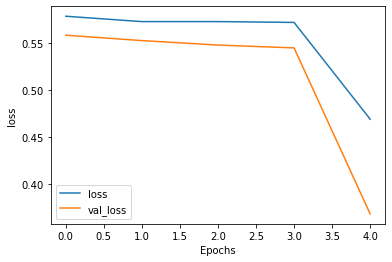

None


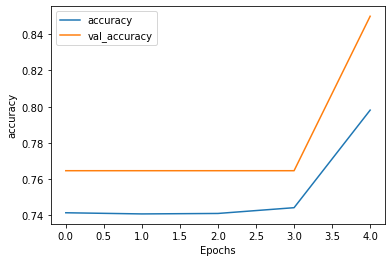

None


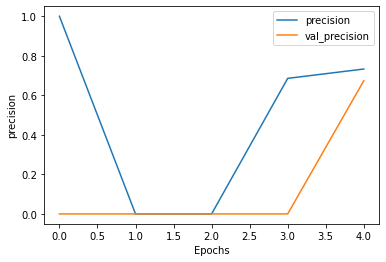

None


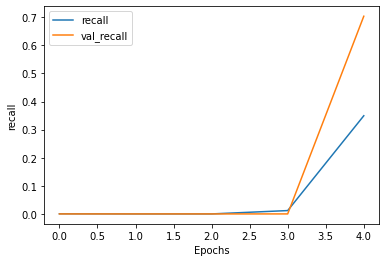

None


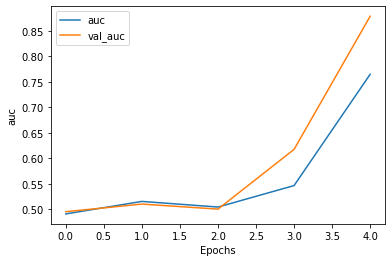

None


In [28]:
print(plot_graphs(history, 'loss'))
print(plot_graphs(history, 'accuracy'))
print(plot_graphs(history, 'precision'))
print(plot_graphs(history, 'recall'))
print(plot_graphs(history, 'auc'))

In [86]:
model.save("rnn_hate_sexual.h5")

In [29]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [30]:
def encode_frase(sample_pred_text):
    sample_pred_text = table.lookup(tf.constant([sample_pred_text.lower().split()]))
    sample_pred_text = tf.make_tensor_proto(sample_pred_text)
    sample_pred_text = tf.make_ndarray(sample_pred_text)
    sample_pred_text = sample_pred_text.tolist()
    sample_pred_text = sample_pred_text[0]
    return sample_pred_text

In [31]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encode_frase(sample_pred_text)
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [34]:
# predict on a sample text with or without padding: True or False

sample_pred_text = "Claro como soy marica me gusta meterme cosas por el culo no? VETE A LA MIERDA."
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)
#print(*predictions.flatten(), sep=', ')

[[0.60447586]]


In [36]:
#PREDICTIONS FROM A FILE

#Read test.txt from the same directory of the Notebook
f=open("validacion_todo.txt", "r", encoding="utf8", errors='ignore')
f1=f.readlines()
for x in f1:
    score = sample_predict(x, pad=True)
    print(x.rstrip('\n \n'), "|", *score.flatten(), "|", "Hate" if score>0.5 else "No hate")


In [52]:
#PRINT PREDICTIONS TO A FILE
original_stdout = sys.stdout

with open('predictions_valida_todo_2.txt', 'w') as f:
    sys.stdout = f 
    #Read test.txt from the same directory of the Notebook
    f=open("txt_todo.txt", "r", encoding="utf8", errors='ignore')
    f1=f.readlines()
    for x in f1:
        score = sample_predict(x, pad=True)
        print(x.rstrip('\n \n'), "|", *score.flatten(), "|", "Hate" if score>0.5 else "No hate")
    sys.stdout = original_stdout 

In [120]:
#!head -5 predictions.txt